In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Take some train samples to create validation set
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_indices, valid_indices = indices[split:], indices[:split]

train = SubsetRandomSampler(train_indices)
valid = SubsetRandomSampler(valid_indices)

In [3]:
from torch.utils.data import DataLoader

batch_size = 16

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

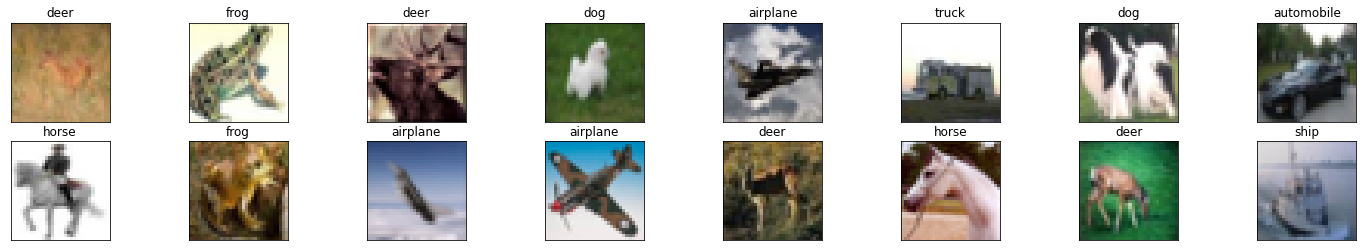

In [5]:
import matplotlib.pyplot as plt

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display a batch of images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

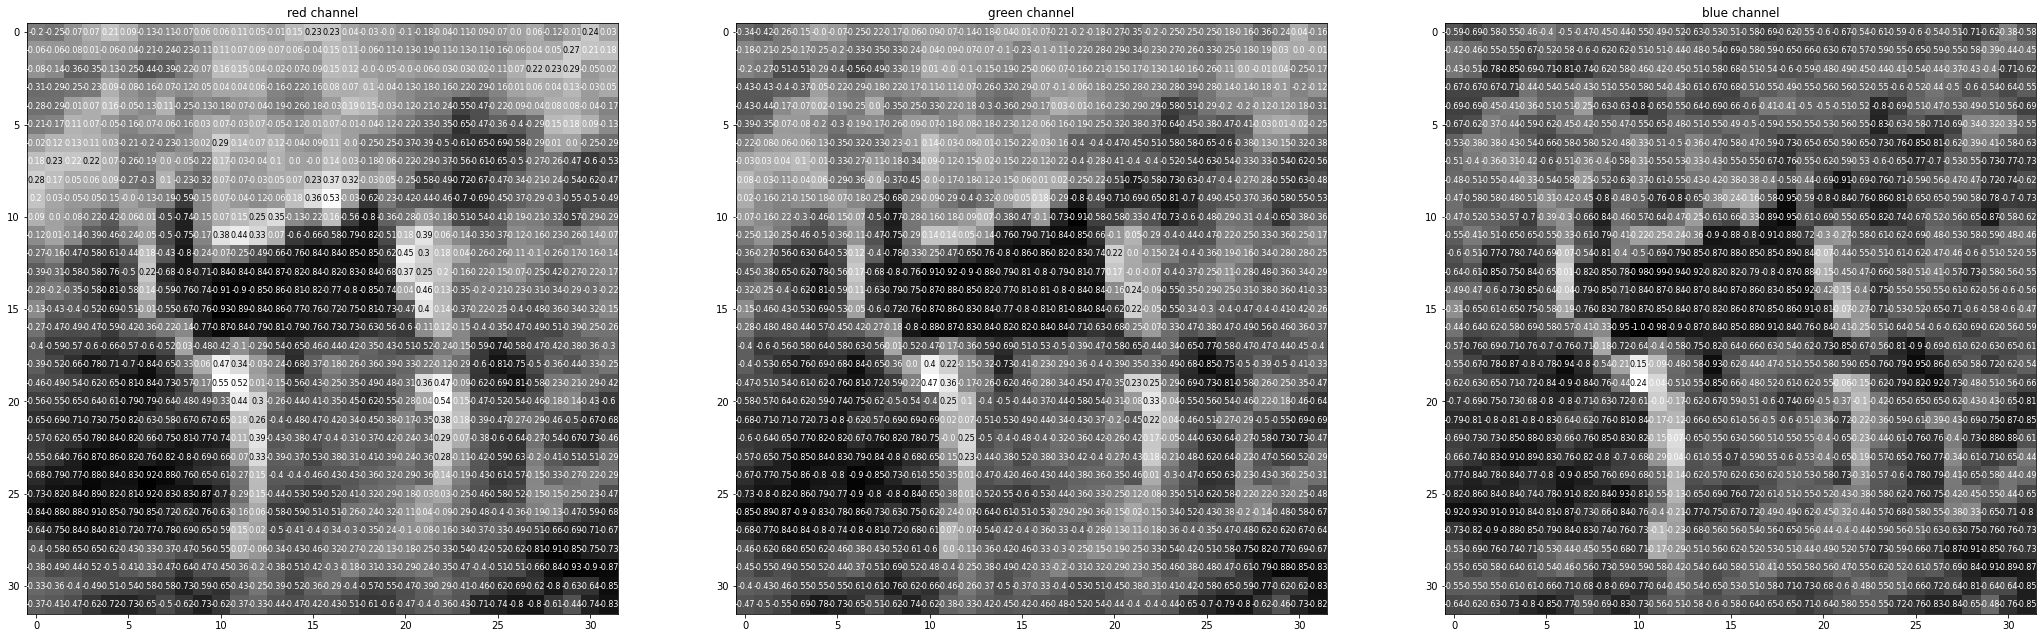

In [6]:
# Here, is the normalized (RGB) color channels as three separate, grayscale intensity images
# Completely unnecessary for our purposes....
rgb_img = np.squeeze(images[12])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [7]:
## Model (from Stanford CS 231N)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.01)

In [10]:
import pickle

# number of epochs to train the model
n_epochs = 5
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        # torch.save(model.state_dict(), 'model_cifar.pt')
        file = open('cifar.model.pkl', 'wb')
        pickle.dump(model, file)
        file.close()
        valid_loss_min = valid_loss
plt.plot(range(n_epochs), train_losslist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of Model')
plt.show()

Epoch: 1 	Training Loss: 1.651189 	Validation Loss: 0.358057
Validation loss decreased (inf --> 0.358057).  Saving model ...
Epoch: 2 	Training Loss: 1.318626 	Validation Loss: 0.303378
Validation loss decreased (0.358057 --> 0.303378).  Saving model ...


KeyboardInterrupt: 

In [ ]:
import torch

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())#  if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
class CNN(nn.Module):
   

    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
# create a complete CNN
cnn_model = CNN()
print(cnn_model)

In [11]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.001)

In [ ]:
# number of epochs to train the model
n_epochs = 5
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    cnn_model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = cnn_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    cnn_model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = cnn_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        file = open('cifar.cnn_model.pkl', 'wb')
        pickle.dump(cnn_model, file)
        file.close()
        valid_loss_min = valid_loss
plt.plot(range(n_epochs), train_losslist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of CNN Model')
plt.show()

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

cnn_model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = cnn_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())#  if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Visual Transformer

In [12]:
class ViT(nn.Module):
    
    # Each 32x32 image will be split into 64 patches, each patch being 4x4 pixels
    # patch_count ==> # of patches across height / width
    # chw = colour, height, width
    def __init__(self, chw=(3, 32, 32), patch_count=8):
        super(ViT, self).__init__()
        
        # Attributes
        self.chw = chw
        self.patch_count = patch_count
    
    # Reshape the images from (N, C, H, W) to (N, Number of patches, Patch dimension)
    def patchify(self, images, patch_count):
        n, c, h, w = images.shape
        # Assuming the images are square -- h == w
        
        patches = torch.zeros(n, patch_count**2, h*w // patch_count**2)
        patch_size = h // patch_count
        
        for idx, image in enumerate(images):
            for k in range(c):
                for i in range(patch_count):
                    for j in range(patch_count):
                        patch = image[k, i*patch_size:(i+1) * patch_size, j * patch_size:(j+1)*patch_size]
                        # Get each sequence (index) and patch
                        patches[idx, i*patch_count+j] = patch.flatten()
        return patches
        
    def forward(self, images):
        patches = self.patchify(images, self.patch_count)
        return patches

In [14]:
# Test model has the right dimensions...
vit = ViT(chw=(3, 32, 32), patch_count=8)
x = torch.randn(12, 3, 32, 32) # Fake image
print(vit(x).shape)

torch.Size([12, 64, 16])


In [15]:
class ViT(nn.Module):
    
    # Add a hidden dimension to the model to map each patch to an 8-element patch
    def __init__(self, chw=(3, 32, 32), patch_count=8, hidden_dim=8):
        super(ViT, self).__init__()
        
        self.chw = chw
        self.patch_count = patch_count
        self.hidden_dim = hidden_dim
        
        # Calculate the size of each patch -- will be different if image is not square
        self.patch_size = (chw[1] / patch_count, chw[2] / patch_count)
        
        # Linear mapper -- must divide input size by 3 (for the colours)
        self.input_dim = int(chw[0] * self.patch_size[0] * self.patch_size[1] / 3)
        self.linear_mapper = nn.Linear(self.input_dim, self.hidden_dim)
    
    
    def patchify(self, images, patch_count):
        n, c, h, w = images.shape
        
        patches = torch.zeros(n, patch_count**2, h*w // patch_count**2)
        patch_size = h // patch_count
        
        for idx, image in enumerate(images):
            for k in range(c):
                for i in range(patch_count):
                    for j in range(patch_count):
                        patch = image[k, i*patch_size:(i+1) * patch_size, j * patch_size:(j+1)*patch_size]
                        # Get each sequence (index) and patch
                        patches[idx, i*patch_count+j] = patch.flatten()
        return patches
        
    def forward(self, images):
        patches = self.patchify(images, self.patch_count)
        # Look at the ViT slide (11) and you'll see an extra learnable class embedding. That's "tokens" here:
        tokens = self.linear_mapper(patches)
        return tokens

In [16]:
# Test model has the right dimensions...
vit = ViT(chw=(3, 32, 32), patch_count=8)
x = torch.randn(12, 3, 32, 32) # Fake image
print(vit(x).shape)

torch.Size([12, 64, 8])


In [17]:
# Adding the classification token

class ViT(nn.Module):
    
    def __init__(self, chw=(3, 32, 32), patch_count=8, hidden_dim=8):
        super(ViT, self).__init__()
        
        self.chw = chw
        self.patch_count = patch_count
        self.hidden_dim = hidden_dim
        
        self.patch_size = (chw[1] / patch_count, chw[2] / patch_count)
        
        self.input_dim = int(chw[0] * self.patch_size[0] * self.patch_size[1] / 3)
        self.linear_mapper = nn.Linear(self.input_dim, self.hidden_dim)
        
        # Learnable classification token -- QQC???
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_dim))
    
    
    def patchify(self, images, patch_count):
        n, c, h, w = images.shape
        
        patches = torch.zeros(n, patch_count**2, h*w // patch_count**2)
        patch_size = h // patch_count
        
        for idx, image in enumerate(images):
            for k in range(c):
                for i in range(patch_count):
                    for j in range(patch_count):
                        patch = image[k, i*patch_size:(i+1) * patch_size, j * patch_size:(j+1)*patch_size]
                        patches[idx, i*patch_count+j] = patch.flatten()
        return patches
        
    def forward(self, images):
        patches = self.patchify(images, self.patch_count)
        tokens = self.linear_mapper(patches)
        # Add classification token
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        return tokens

In [18]:
# Test model has the right dimensions...
vit = ViT(chw=(3, 32, 32), patch_count=8)
x = torch.randn(12, 3, 32, 32) # Fake image
print(vit(x).shape)

torch.Size([12, 65, 8])


In [19]:
# Add positional encoding...
# https://arxiv.org/abs/1706.03762 suggests it's better to add sin/cos encodings rather than absolute position
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [20]:
# Adding the classification token

class ViT(nn.Module):
    
    def __init__(self, chw=(3, 32, 32), patch_count=8, hidden_dim=8):
        super(ViT, self).__init__()
        
        self.chw = chw
        self.patch_count = patch_count
        self.hidden_dim = hidden_dim
        
        self.patch_size = (chw[1] / patch_count, chw[2] / patch_count)
        
        self.input_dim = int(chw[0] * self.patch_size[0] * self.patch_size[1] / 3)
        self.linear_mapper = nn.Linear(self.input_dim, self.hidden_dim)
        
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_dim))
        
        # Add positional encoding...
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.patch_count**2 + 1, self.hidden_dim)))
        self.pos_embed.requires_grad = False
    
    
    def patchify(self, images, patch_count):
        n, c, h, w = images.shape
        
        patches = torch.zeros(n, patch_count**2, h*w // patch_count**2)
        patch_size = h // patch_count
        
        for idx, image in enumerate(images):
            for k in range(c):
                for i in range(patch_count):
                    for j in range(patch_count):
                        patch = image[k, i*patch_size:(i+1) * patch_size, j * patch_size:(j+1)*patch_size]
                        patches[idx, i*patch_count+j] = patch.flatten()
        return patches
        
    def forward(self, images):
        # Need to know whte number of images, patches, etc.
        n, c, h, w = images.shape
        
        patches = self.patchify(images, self.patch_count)
        tokens = self.linear_mapper(patches)
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        
        # Add positional embedding & use that as the output
        pos_embed = self.pos_embed.repeat(n, 1, 1)
        out = tokens + pos_embed
        return out

In [21]:
# Test model has the right dimensions...
vit = ViT(chw=(3, 32, 32), patch_count=8)
x = torch.randn(12, 3, 32, 32) # Fake image
print(vit(x).shape)

torch.Size([12, 65, 8])


/var/folders/m5/hdvfpk_j4xs59rn2w6mytrqr0000gp/T/ipykernel_45896/2810398137.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.patch_count**2 + 1, self.hidden_dim)))


In [22]:
# The encoder block
# 1: Layer Norm
# 2: Multi-head self-attention (MSA) -- how similar is this thing to what we've seen before (q, k, v)?

In [37]:
# Best to do this as its own class?

class MSA(nn.Module):
    
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        
        assert d % n_heads == 0, f'Cannot divide dimension{d} into {n_heads} heads'
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                seq = sequence[:,head * self.d_head: (head+1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                attention = softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(sel_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [24]:
# Add a residual connection to persist the original input
# This class contains the MSA above, of course.

class ViTBlock(nn.Module):
    
    def __init__(self, hidden_d, n_heads):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        
    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out

In [40]:
# Add the LauerNorm, etc. to this ViTBlock

class ViTBlock(nn.Module):
    
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),   # Gaussian Error Linear Units
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        
    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.ml(self.norm2(out))
        return out

In [41]:
model = ViTBlock(hidden_d=8, n_heads=2)

# x = torch.randn(7, 50, 8)
# print(model(x).shape)

x = torch.randn(12, 3, 32, 3drive2) # Fake image
print(model(x).shape)

RuntimeError: Given normalized_shape=[8], expected input with shape [*, 8], but got input of size[12, 3, 32, 32]